This is the SVM classifier. It maps out data in a space to then try to draw a line (hyperplane) between the data points to max out the space between the closest data points in each category. The data points closest to the hyperplane in each category have their own lines (support vectors) that defines the margin.

To do this we need to import our libraries. (BEFORE UPLOAD remove unused ones)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

We then load the data.

In [12]:
car_data = pd.read_csv('data/ALL_CARS_DATA.csv')

The goal is to classify different types of Chevrolets, so we will extract the all the Chevrolets to its own structure. (im filtering also to see how many rows we lose if we just drop everything with empty cells.)

In [13]:
chevy = car_data[car_data['BRAND'] == 'Chevrolet']
print('Rows before cleaning', len(chevy))
chevy = chevy.dropna()
print('Rows after cleaning', len(chevy))


Rows before cleaning 26689
Rows after cleaning 26647


The goal with this classifier is to predict the stock type (which in this case is is either "New", "Used" or "Chevrolet Certified"), so we put our predictors in X and the target in Y.

In [14]:
X = chevy[['AGE OF CAR', 'MILEAGE', 'RATING']]
Y = chevy['STOCK TYPE']

We need to scale the numerical features so all features get as much 'room' as needed. If it's not scaled it might cause the data to be very skewed which is something we want to avoid. We encode the target categories as well.

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

l_encoder = LabelEncoder()
Y_encoded = l_encoder.fit_transform(Y)

We split the data into training/test data

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=69)

Now we train the model. Since "Chevrolet Certified" is very underrepresented we will put the class weight to balanced, otherwise the model never predicts it. We will do another run where we use SMOTE, which will be explained later.

In [17]:
svm_classifier = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=69)
svm_classifier.fit(X_train, Y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


Now we evaluate and see if the model is working well.

In [42]:
Y_pred = svm_classifier.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {acc}")

report = classification_report(Y_test, Y_pred, target_names=l_encoder.classes_)
print(report)

Accuracy: 0.8311573076435543
                     precision    recall  f1-score   support

Chevrolet Certified       0.70      0.88      0.78      2616
                New       0.97      1.00      0.99      2686
               Used       0.85      0.61      0.71      2587

           accuracy                           0.83      7889
          macro avg       0.84      0.83      0.83      7889
       weighted avg       0.84      0.83      0.83      7889



We can see that we are predicting all the new cars correctly, with a small amount of false positives. We are getting a lot of false positives in Chevrolet Certified, most likely predicting Used ones as this. There are very few false positives in the Used category, but not all the used cars were put into this category since some of them got put into Chevrolet Certified.

The class_weight='balanced' is making the model predict more Chevrolet Certified than there should be to compensate for it being underrepresented. Without it the model doesn't predict this category at all.

Let's try a different approach. We will use the Synthetic Minority Over-sampling Technique (SMOTE), which uses kNN to generate samples of the smaller categories, in this case Chevrolet Certified. This balances the dataset. We train the classifier again with the new SMOTEd data.

In [19]:
smote = SMOTE(random_state=69)

X_smoted, Y_smoted = smote.fit_resample(X_scaled, Y_encoded)

X_train, X_test, Y_train, Y_test = train_test_split(X_smoted, Y_smoted, test_size=0.2, random_state=69)

svm_classifier = SVC(kernel='rbf', C=1, random_state=69)
svm_classifier.fit(X_train, Y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


We evaluate our new data.

In [20]:
Y_pred = svm_classifier.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {acc}")

report = classification_report(Y_test, Y_pred, target_names=l_encoder.classes_)
print(report)

Accuracy: 0.8311573076435543
                     precision    recall  f1-score   support

Chevrolet Certified       0.70      0.88      0.78      2616
                New       0.97      1.00      0.99      2686
               Used       0.85      0.61      0.71      2587

           accuracy                           0.83      7889
          macro avg       0.84      0.83      0.83      7889
       weighted avg       0.84      0.83      0.83      7889



We can see that our accuracy is higher and that results are more balanced across the classes.
Let's visualize this.

Amount of cars tested in each category:
New                    2686
Chevrolet Certified    2616
Used                   2587
Name: count, dtype: int64


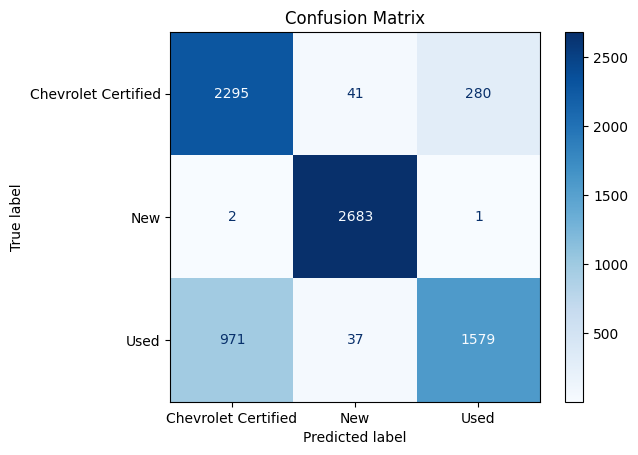

In [41]:
Y_test_str = l_encoder.inverse_transform(Y_test)
Y_pred_str = l_encoder.inverse_transform(Y_pred)

print("Amount of cars tested in each category:")
print(pd.Series(Y_test_str).value_counts())

cm = confusion_matrix(Y_test_str, Y_pred_str, labels=l_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=l_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()